In [49]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os, sys

In [50]:
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import os, sys
curruser = os.environ.get('USER')
sys.path.insert(0, './../src/')
sys.path.insert(0, '/home/{}/notebooks/support_library/'.format(curruser)) 
sys.path.insert(0, '/home/{}/python35-libs/lib/python3.5/site-packages/'.format(curruser))
# sys.path.insert(0, '/home/ufimtsev1-ys_ca-sbrf-ru/notebooks/labdata/lib/')

import re 
import time
import joblib
import gc
import numpy as np
import pandas as pd
import subprocess
# from sshloader import Ssh

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_columns = 1000


# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.set_option('display.max_colwidth', -1)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

from csv import QUOTE_ALL 

from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
# tqdm_notebook.pandas()

import feature_importance

from collections import Counter
from imblearn import over_sampling
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, \
                            classification_report, precision_score, \
                            recall_score, roc_curve, precision_recall_curve, \
                            average_precision_score, make_scorer, confusion_matrix, get_scorer

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from time import time

In [7]:
def get_metrics(y_pred, y, average='binary'):
    print(classification_report(y, y_pred, digits=5, ))
    recall = recall_score(y, y_pred, average=average)
    precision=precision_score(y, y_pred,average=average)
    f1=f1_score(y, y_pred,average=average)
    
    return recall, precision, f1

In [8]:
def feature_impotance(model, X_train, count_top_features = 20):
    imp=model.feature_importances_
    names=X_train.columns
    imp, names=map(list, zip(*sorted(zip(imp, names))[::-1][:count_top_features]))
    
    fig, ax = plt.subplots(figsize=(9,12))
    #ax = plt.axes()
    sns.barplot(x=imp, y=names, palette=sns.color_palette('YlGn', 2), ax=ax)
    ax.set_title('Top ' + str(count_top_features) + ' important features')
    plt.show()

## Fetch data for Train

In [9]:
%%time
csvpath = Path.joinpath(Path(os.getcwd()),'csv','data4train_sampled_60pct.csv')
df_part = pd.read_csv(csvpath, encoding='cp1251', sep=';', compression='gzip')

# df_part = pd.read_csv(filepath_or_buffer = csvpath, sep = ';', compression = 'gzip', engine='python',
#                  dtype = {'target' : np.int32, 'OPF_IP': np.float32 ,'OPF_OOO': np.float32 ,'OPF_Other': np.float32 ,'ab_borrowed_capital': np.float32 ,'ab_immobilized_assets': np.float32 ,'ab_losses': np.float32 ,'ab_own_capital': np.float32 ,'acquiring_mobile': np.float32 ,'acquiring_torg': np.float32 ,'acreditiv': np.float32 ,'active_flg': np.float32 ,'all_prod_deals_completed': np.float32 ,'all_prod_deals_created': np.float32 ,'arenda_seyf': np.float32 ,'bank_straxovanie_imush': np.float32 ,'bank_straxovanie_lich': np.float32 ,'bank_straxovanie_otvet': np.float32 ,'branch_cnt': np.float32 ,'campaign_nm': np.float32 ,'cash_management': np.float32 ,'corp_cards': np.float32 ,'corp_cards_prod_deals_completed': np.float32 ,'corp_cards_prod_deals_created': np.float32 ,'corporate_cards': np.float32 ,'cred_application_cnt': np.float32 ,'cred_sdo': np.float32 ,'credit': np.float32 ,'credit_prod_deals_completed': np.float32 ,'credit_prod_deals_created': np.float32 ,'dbo': np.float32 ,'deposit': np.float32 ,'deposit_sertificat': np.float32 ,'deposits': np.float32 ,'depozit_prod_deals_completed': np.float32 ,'depozit_prod_deals_created': np.float32 ,'egr_org_id': np.float32 ,'egrul_org_id': np.float32 ,'einvoicing': np.float32 ,'email': np.float32 ,'factoring': np.float32 , 'fot_balance': np.float32, 'founders_all_cnt': np.float32 ,'founders_fl_cnt': np.float32 ,'founders_foreign_ul_cnt': np.float32 ,'founders_ul_cnt': np.float32 ,'fresh_user': np.float32 ,'garantee_gos': np.float32 ,'garantee_kontract': np.float32 ,'garantee_other': np.float32 ,'gis_bank_payment_flg': np.float32 ,'gis_card_payment_flg': np.float32 ,'gis_cash_payment_flg': np.float32 ,'gis_internet_merchant_flg': np.float32 ,'gis_internet_payment_flg': np.float32 ,'gis_merchant_cnt': np.float32 ,'gis_network_flg': np.float32 ,'gis_opt_merchant_flg': np.float32 ,'gis_production_merchant_flg': np.float32 ,'gis_rosn_merchant_flg': np.float32 ,'industry': np.float32 ,'inkass': np.float32 ,'insure_prod_deals_completed': np.float32 ,'insure_prod_deals_created': np.float32 ,'integrum_lower_bound': np.float32 ,'invest_kredit': np.float32 ,'ip_flg': np.float32 ,'konversion': np.float32 ,'kpp_regions_cnt': np.float32 ,'last_click_all_cnt_m11': np.float32 ,'last_click_all_cnt_m21': np.float32 ,'last_click_all_cnt_m31': np.float32 ,'last_click_day_cnt_m11': np.float32 ,'last_click_day_cnt_m21': np.float32 ,'last_click_day_cnt_m31': np.float32 ,'last_open_all_cnt_m11': np.float32 ,'last_open_all_cnt_m21': np.float32 ,'last_open_all_cnt_m31': np.float32 ,'last_open_day_cnt_m11': np.float32 ,'last_open_day_cnt_m21': np.float32 ,'last_open_day_cnt_m31': np.float32 ,'license_cnt': np.float32 ,'main_inn': np.float32 ,'main_kpp': np.float32 ,'main_organization_id': np.float32 ,'max_zp_empl_cnt': np.float32 ,'merch': np.float32 ,'merch_prod_deals_completed': np.float32 ,'merch_prod_deals_created': np.float32 ,'min_zp_empl_cnt': np.float32 ,'ns_servis': np.float32 ,'ns_terminal': np.float32 ,'oborot_kredit': np.float32 ,'obsluzh_rts_rur': np.float32 ,'obsluzh_rts_val': np.float32 ,'overdraft_kredit': np.float32 ,'products_lizing': np.float32 ,'proekt_finans': np.float32 ,'rko': np.float32 ,'salary': np.float32 ,'salary_prod_deals_completed': np.float32 ,'salary_prod_deals_created': np.float32 ,'samoinkass': np.float32 ,'spec_acc': np.float32 ,'stoplist': np.float32 ,'target': np.float32 ,'tb_Centralno_Chernozemnyj': np.float32 ,'tb_Dalnevostochnyj': np.float32 ,'tb_Moskovskij': np.float32 ,'tb_Povolzhskij': np.float32 ,'tb_Severo_Zapadnyj': np.float32 ,'tb_Uralskij': np.float32 ,'tb_Volgo_Vyatskij': np.float32 ,'total_count_dt': np.float32 ,'total_count_dt_3m': np.float32 ,'total_count_dt_year18': np.float32 ,'total_count_kt': np.float32 ,'total_count_kt_3m': np.float32 ,'total_count_kt_year18': np.float32 ,'ul_org_id': np.float32 ,'valuta_control': np.float32 ,'veksel': np.float32 ,'zarplat_projects': np.float32, 'sum_open_click_camp': np.float32, 'ul_kopf_cd': np.float32 },   
#                  usecols = lambda columns : columns not in ['text', 'text_norm', 'inn', 'kpp', 'organization_id', 'email','campaign_nm', 'idx', 'fresh_user', 'complicity_type', 'ogrn', 'sum_open_click_camp'] 
#                  )

CPU times: user 12min 5s, sys: 1min 12s, total: 13min 17s
Wall time: 13min 18s


In [10]:
X_train, X_test, y_train, y_test = \
train_test_split(df_part.drop(['target'], axis=1), df_part.target, 
                 random_state=42, shuffle=True, test_size=0.2)

# Probabilities Calibration 

In [206]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import OneHotEncoder

In [12]:
import matplotlib.pyplot as plt
import ast

### Load Pretrained XGB Model

In [28]:
classifier = joblib.load('./pkl/xgb_cls_tuned_pipe_wFT_200606.pkl')
xgb = classifier['clf']
xgb

XGBClassifier(bagging_fraction=0.5, bagging_freq=0, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bytree=0.7,
              feature_fraction=0.7, gamma=0, lambda_l1=0, lambda_l2=0.01,
              learning_rate=0.08, max_bin=180, max_delta_step=0, max_depth=10,
              min_child_samples=100, min_child_weight=1e-05,
              min_data_in_leaf=100, missing=nan, n_estimators=500, n_jobs=40,
              nthread=None, num_leaves=128, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2.041, seed=None, silent=True, subsample=1, ...)

In [29]:
y_pred = xgb.predict(X_test.astype(dtype=np.float32))

recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.75427   0.72150   0.73752    922443
           1    0.47794   0.52032   0.49823    452018

    accuracy                        0.65533   1374461
   macro avg    0.61610   0.62091   0.61787   1374461
weighted avg    0.66339   0.65533   0.65882   1374461

Hold Out: 
Precision: 0.47794, Recall: 0.52032, F_1: 0.49823


### Probabilities

In [421]:
try:
    y_proba = xgb.predict_proba(X_test.astype(float))[:, 1]
except ValueError as err:
    colsstr     = str(err).split('feature_names mismatch: ')[1].split(' [')[0]
    getcolslist = list(ast.literal_eval(colsstr[1:-1]))            
    y_proba = xgb.predict_proba(X_test[getcolslist].astype(float))[:, 1]  

### Plot Mean Actual Pos Fractions vs Mean Predicted

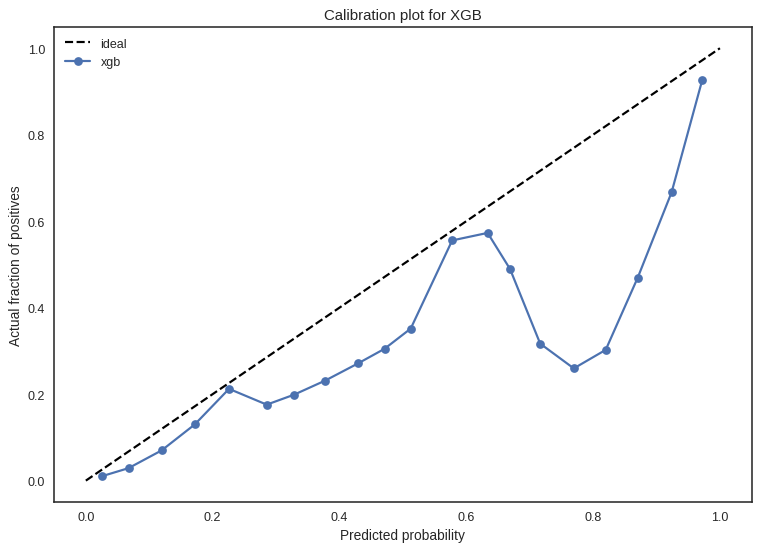

In [17]:
# creating a dataframe of target and probabilities
prob_df_xgb = pd.DataFrame({'y':y_test, 'y_hat': y_proba})

# binning the dataframe, so we can see success rates for bins of probability
bins = np.arange(0.05, 1.00, 0.05)
prob_df_xgb.loc[:,'prob_bin'] = np.digitize(prob_df_xgb['y_hat'], bins)
prob_df_xgb.loc[:,'prob_bin_val'] = prob_df_xgb['prob_bin'].replace(dict(zip(range(len(bins)), bins)))

# opening figure
plt.figure(figsize=(10,7), dpi=90)

plt.style.use('seaborn-white')

# plotting ideal line
plt.plot([0,1],[0,1], 'k--', label='ideal')

# plotting calibration for xgb
calibration_y = prob_df_xgb.groupby('prob_bin_val')['y'].mean()
calibration_x = prob_df_xgb.groupby('prob_bin_val')['y_hat'].mean()
plt.plot(calibration_x, calibration_y, marker='o', label='xgb')

# legend and titles
plt.title('Calibration plot for XGB')
plt.xlabel('Predicted probability')
plt.ylabel('Actual fraction of positives')
plt.legend()
plt.show()

In [420]:
X_train.shape

(5497840, 514)

In [ ]:
###########################################################################################
########## Make sklearn CalibratedClassifierCV compartible with XGBoost class #############
###########################################################################################

# /home/$USER/python35-libs/lib/python3.5/site-packages/sklearn/calibration.py
# Add to the init method of CalibratedClassifierCV class new parameter xdtype:
'''
    def __init__(self, base_estimator=None, method='sigmoid', cv='warn', xdtype='numeric'):
        self.base_estimator = base_estimator
        self.method = method
        self.cv = c_v
        self.xdtype = xdtype
'''
# Pass this param to the argument list of function Check_X_y being called at Fit() method 
'''
    def fit(self, X, y, sample_weight=None):
        """Fit the calibrated model

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.

        y : array-like, shape (n_samples,)
            Target values.

        sample_weight : array-like, shape = [n_samples] or None
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
        """

        X, y = check_X_y(X, y, accept_sparse=['csc', 'csr', 'coo'],
                         force_all_finite=False, allow_nd=True, dtype=self.xdtype)
'''

# Go to /home/$USER/python35-libs/lib/python3.5/site-packages/sklearn/utils/validation.py
'''
def check_array(array, accept_sparse=False, accept_large_sparse=True,
                dtype="numeric", order=None, copy=False, force_all_finite=True,
                ensure_2d=True, allow_nd=False, ensure_min_samples=1,
                ensure_min_features=1, warn_on_dtype=None, estimator=None):
'''

# set `dtype_numeric` var to True and add this reinitialization in the following `if else` block:
'''
    if isinstance(dtype, (list, tuple)):
        if dtype_orig is not None and dtype_orig in dtype:
            # no dtype conversion required
            dtype = None
        else:
            # dtype conversion required. Let's select the first element of the
            # list of accepted types.
            dtype = dtype[0]
        dtype_numeric = True
'''
# and last step is to slightly modify the next `if else` block:
'''
    if sp.issparse(array):
        _ensure_no_complex_data(array)
        array = _ensure_sparse_format(array, accept_sparse=accept_sparse,
                                      dtype=dtype, copy=copy,
                                      force_all_finite=force_all_finite,
                                      accept_large_sparse=accept_large_sparse)
    else:
        # If np.array(..) gives ComplexWarning, then we convert the warning
        # to an error. This is needed because specifying a non complex
        # dtype to the function converts complex to real dtype,
        # thereby passing the test made in the lines following the scope
        # of warnings context manager.
        with warnings.catch_warnings():
            try:
                warnings.simplefilter('error', ComplexWarning)
                if dtype_numeric:
                    array = np.asarray(array, dtype=dtype, order=order)
            except ComplexWarning:
                raise ValueError("Complex data not supported\n"
                                 "{}\n".format(array))
'''
# In order to avoid errors like: 
# "sklearn/_isotonic.pyx in sklearn._isotonic._make_unique()
#  ValueError: Buffer dtype mismatch, expected 'float' but got 'double'"
# modify fit method in isotonic.py file (/home/$USER/python35-libs/lib/python3.5/site-packages/sklearn/isotonic.py)
'''
        check_params = dict(accept_sparse=False, ensure_2d=False)
        X = check_array(X, dtype=[np.float32], **check_params)
        y = check_array(y, dtype=[np.float32], **check_params)
'''

X shape is: (5497840,); X type is: float32
y shape is: (5497840,); y type is: float32


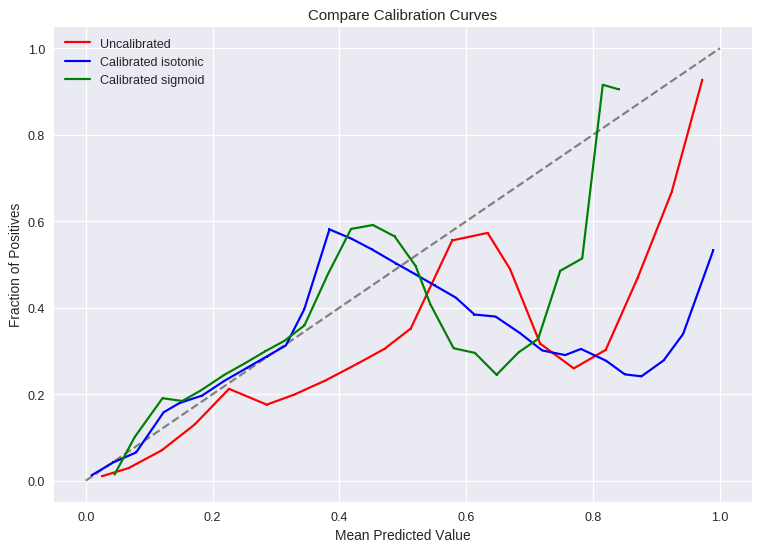

In [197]:
# use CalibratedClassifierCV with sigmoid and isotonic parameters

plt.figure(figsize=(10,7), dpi=90)
plt.style.use('seaborn-white')

fraction_of_pos, mean_pred_val = calibration_curve(y_test, y_proba, n_bins=20)
plt.plot(mean_pred_val, fraction_of_pos, 's-', markersize=2, color='red', label='Uncalibrated')
plt.plot([0,1],[0,1],'--',color='gray')

methodlst=['isotonic','sigmoid',]
clr=['blue','green']
i=0
for method in methodlst:
    clf_calib=CalibratedClassifierCV(xgb, cv='prefit', method=method, xdtype=pd.core.frame.DataFrame)
  
    try:
        clf_calib.fit(X_train.astype(dtype=np.float32), y_train.astype(dtype=np.float32))
    except ValueError as err:
        print("Cols mismatched... Try to catch cols order from error message-->")
        colsstr     = str(err).split('feature_names mismatch: ')[1].split(' [')[0]
        getcolslist = list(ast.literal_eval(colsstr[1:-1]))
        _X_train = X_train[getcolslist].astype(dtype=np.float32)
        clf_calib.fit(_X_train, y_train)
        
    y_tst_clf_calib_proba=clf_calib.predict_proba(X_test.astype(dtype=np.float32))[:,1]
    fraction_of_pos, mean_pred_val = calibration_curve(y_test, y_tst_clf_calib_proba, n_bins=30)
    plt.plot(mean_pred_val, fraction_of_pos, 's-', markersize=2, color=clr[i], label='Calibrated %s' % method)
    i=i+1
    
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.legend(loc='best')
plt.title('Compare Calibration Curves')
plt.show()

## Choose SigmoId Method and obtain recalibated proba

In [422]:
methodlst=['sigmoid']
for method in methodlst:
    clf_calib=CalibratedClassifierCV(xgb, cv='prefit', method=method, xdtype=pd.core.frame.DataFrame)
  
    try:
        clf_calib.fit(X_train.astype(dtype=np.float32), y_train.astype(dtype=np.float32))
    except ValueError as err:
        print("Cols mismatched... Try to catch cols order from error message-->")
        colsstr     = str(err).split('feature_names mismatch: ')[1].split(' [')[0]
        getcolslist = list(ast.literal_eval(colsstr[1:-1]))
        _X_train = X_train[getcolslist].astype(dtype=np.float32)
        clf_calib.fit(_X_train, y_train)
        
    y_tst_clf_calib_proba=clf_calib.predict_proba(X_test.astype(dtype=np.float32))[:,1]
 

In [428]:
joblib.dump(clf_calib,'./pkl/CalibratedClassifierCV_xgb.pkl')

['./pkl/CalibratedClassifierCV_xgb.pkl']

In [423]:
# classification report after recalibration of proba
threshold=0.50
y_pred = binarize(y_tst_clf_calib_proba.reshape(-1, 1), threshold=threshold).reshape(-1)

recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.73357   0.77977   0.75596    922443
           1    0.48429   0.42206   0.45104    452018

    accuracy                        0.66213   1374461
   macro avg    0.60893   0.60091   0.60350   1374461
weighted avg    0.65159   0.66213   0.65568   1374461

Hold Out: 
Precision: 0.48429, Recall: 0.42206, F_1: 0.45104


In [425]:
#compare with tuned XGB
y_pred = xgb.predict(X_test.astype(dtype=np.float32))

recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.75427   0.72150   0.73752    922443
           1    0.47794   0.52032   0.49823    452018

    accuracy                        0.65533   1374461
   macro avg    0.61610   0.62091   0.61787   1374461
weighted avg    0.66339   0.65533   0.65882   1374461

Hold Out: 
Precision: 0.47794, Recall: 0.52032, F_1: 0.49823


In [426]:
gc.collect()

2

In [202]:
del y_proba
del clf_calib
del y_tst_clf_calib_proba, fraction_of_pos, mean_pred_val

# TRAIN: Logistic Regression on the leaves of forests

In [411]:
# use the .apply method to get the indices of the leaves each sample ended up into.
try:
#     X_train = X_train.astype(float)
    leaves = xgb.apply(X_train.astype(dtype=np.float32))
except ValueError as err:
    colsstr = str(err).split('feature_names mismatch: ')[1].split(' [')[0]
    getcolslist = list(ast.literal_eval(colsstr[1:-1]))       
    leaves = xgb.apply(X_train[getcolslist].astype(dtype=np.float32))

In [412]:
n = np.max(leaves)+1
_, n_features = leaves.shape
n_features

500

In [219]:
leaves[:3]

array([[ 688,  573,  745, ...,  733,  485,  297],
       [ 895,  773, 1114, ...,  733,  485,  297],
       [ 693,  592,  775, ...,  739,  485,  297]], dtype=int32)

In [413]:
# then, we one-hot encode the leave indexes so we can use them in the logistic regression
encoder = OneHotEncoder(categories = [range(n)]*n_features, sparse=True, dtype=np.int32)
leaves_encoded = encoder.fit_transform(leaves)

In [221]:
leaves_encoded

<5497840x823500 sparse matrix of type '<class 'numpy.int32'>'
	with 2748920000 stored elements in Compressed Sparse Row format>

In [ ]:
# get_n_values = len(encoder.active_features_)

In [414]:
del leaves
del encoder
gc.collect()

259

## Initialize LR incremental modeling with mini-batches

In [415]:
# we configure the logistic regression and fit it to the encoded leaves
from sklearn.linear_model.logistic import LogisticRegression

In [416]:
batches = np.array_split(np.arange(leaves_encoded.shape[0]), 15)

In [417]:
y_train.reset_index(drop=True, inplace=True)

In [418]:
lr = LogisticRegression(solver='sag', C=10**(-4), max_iter=1000, n_jobs=40, fit_intercept=False, warm_start=True)

for batch in tqdm_notebook(batches, total=len(batches)):
    lr.fit(leaves_encoded[batch], y_train[batch])

In [419]:
import pickle
with open('./pkl/xgb_cls_tuned_pipe_wFT_wLR_200612.pkl', 'wb') as f:
    pickle.dump(lr, f)

## TRAIN: Let us check probabilities before and after logistic regression

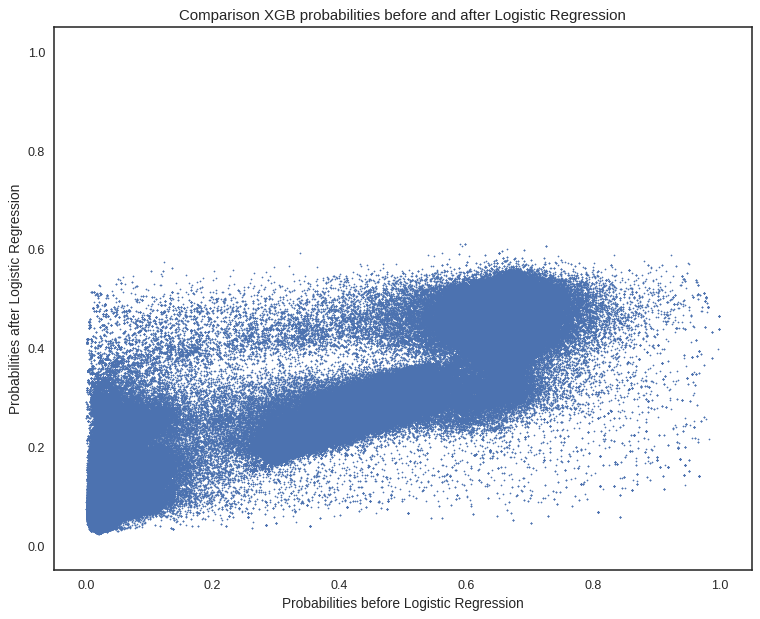

In [328]:
preds_xgblr = lr.predict_proba(leaves_encoded)

try:
    preds_xgb = xgb.predict_proba(X_train.astype(dtype=np.float32))
except ValueError as err:
    colsstr     = str(err).split('feature_names mismatch: ')[1].split(' [')[0]
    getcolslist = list(ast.literal_eval(colsstr[1:-1]))           
    preds_xgb   = xgb.predict_proba(X_train[getcolslist].astype(dtype=np.float32)) 

# plotting the probabilities
plt.figure(figsize=(10,8), dpi=90)
plt.scatter(preds_xgb[:,1], preds_xgblr[:,1], s=1)
plt.xlim(-0.05,1.05); plt.ylim(-0.05,1.05)

# adding text
plt.title('Comparison XGB probabilities before and after Logistic Regression')
plt.xlabel('Probabilities before Logistic Regression')
plt.ylabel('Probabilities after Logistic Regression')

In [329]:
del leaves_encoded
del preds_xgblr
del preds_xgb

In [330]:
Out.clear()
gc.collect()

159

## OOB: Validate recalibrated estimator

In [361]:
def softmax(x):
    return np.exp(x)/(np.sum(np.exp(x)))

In [349]:
# use the .apply method to get the indices of the leaves each sample ended up into.
try:
#     X_train = X_train.astype(float)
    leaves = xgb.apply(X_test.astype(dtype=np.float32))
except ValueError as err:
    colsstr = str(err).split('feature_names mismatch: ')[1].split(' [')[0]
    getcolslist = list(ast.literal_eval(colsstr[1:-1]))       
    leaves = xgb.apply(X_test[getcolslist].astype(dtype=np.float32))

_, n_features = leaves.shape

encoder = OneHotEncoder(categories = [range(n)]*n_features, sparse=True, dtype=np.int32)
leaves_encoded = encoder.fit_transform(leaves)

del encoder
del leaves

In [332]:
leaves_encoded

<1374461x823500 sparse matrix of type '<class 'numpy.int32'>'
	with 687230500 stored elements in Compressed Sparse Row format>

## TEST: Let us check probabilities before and after logistic regression

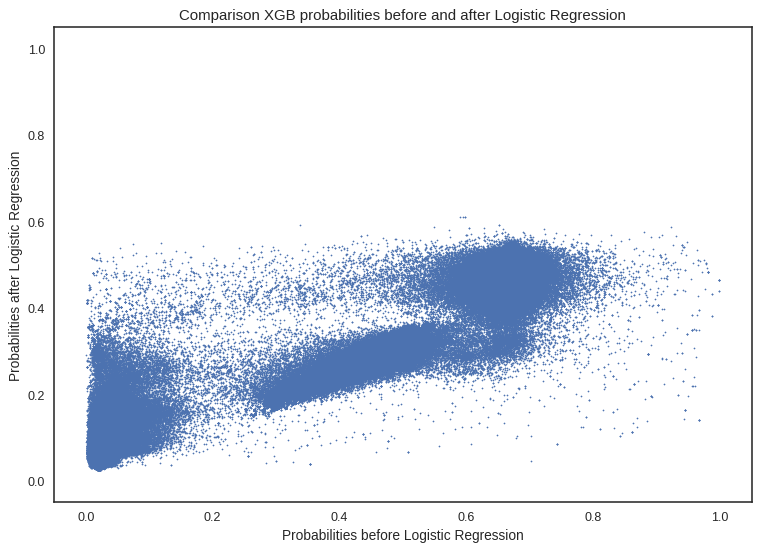

In [350]:
# let us check probabilities before and after logistic regression
preds_xgblr = lr.predict_proba(leaves_encoded)

try:
    preds_xgb = xgb.predict_proba(X_test.astype(dtype=np.float32))
except ValueError as err:
    colsstr     = str(err).split('feature_names mismatch: ')[1].split(' [')[0]
    getcolslist = list(ast.literal_eval(colsstr[1:-1]))           
    preds_xgb   = xgb.predict_proba(X_test[getcolslist].astype(dtype=np.float32)) 

# plotting the probabilities
plt.figure(figsize=(10,7), dpi=90)
plt.scatter(preds_xgb[:,1], preds_xgblr[:,1], s=1)
plt.xlim(-0.05,1.05); plt.ylim(-0.05,1.05)

# adding text
plt.title('Comparison XGB probabilities before and after Logistic Regression')
plt.xlabel('Probabilities before Logistic Regression')
plt.ylabel('Probabilities after Logistic Regression')

In [370]:
preds_xgblr.max(), preds_xgb.max()

(0.9757844782247824, 0.9989896)

# Plot Calibration Curves After LR

In [339]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, binarize

## Try to use different scaling approaches

In [374]:
max_proba = np.max(preds_xgblr[:,1])
min_proba = np.min(preds_xgblr[:,1])

scaled_proba_lr = [(proba-min_proba)/(max_proba-min_proba) for proba in preds_xgblr[:,1]]

In [371]:
scaler = StandardScaler()
preds_xgblr_scl = scaler.fit_transform(preds_xgblr[:,1].reshape(-1, 1))

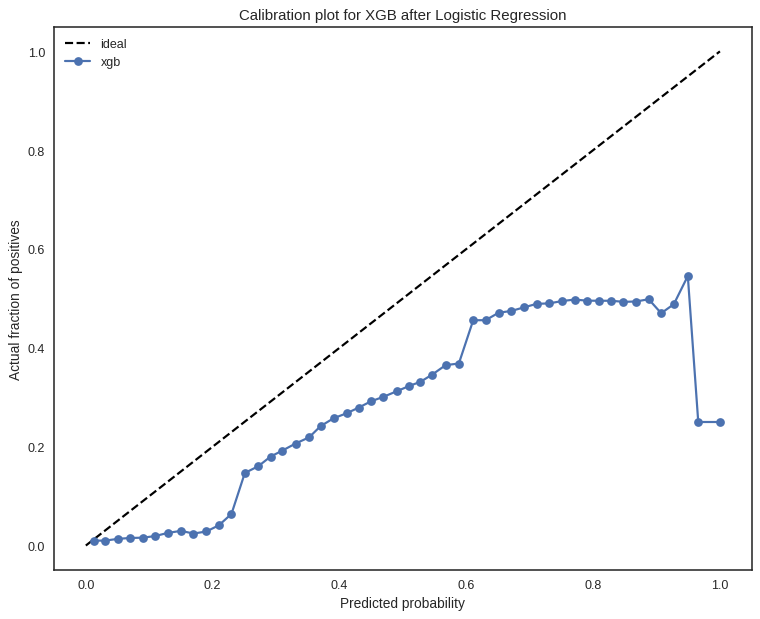

In [375]:
# creating a dataframe of target and probabilities
prob_df_xgblr = pd.DataFrame({'y':y_test, 'y_hat': scaled_proba_lr}) #np.squeeze(preds_xgblr_scl)

# binning the dataframe, so we can see success rates for bins of probability
bins = np.arange(0.02, 1, 0.02)
prob_df_xgblr.loc[:,'prob_bin'] = np.digitize(prob_df_xgblr['y_hat'], bins)
prob_df_xgblr.loc[:,'prob_bin_val'] = prob_df_xgblr['prob_bin'].replace(dict(zip(range(len(bins)), bins)))

# opening figure
plt.figure(figsize=(10,8), dpi=90)
plt.style.use('seaborn-white')

# plotting ideal line
plt.plot([0,1],[0,1], 'k--', label='ideal')

# plotting calibration for xgb
calibration_y = prob_df_xgblr.groupby('prob_bin_val')['y'].mean()
calibration_x = prob_df_xgblr.groupby('prob_bin_val')['y_hat'].mean()
plt.plot(calibration_x, calibration_y, marker='o', label='xgb')

# legend and titles
plt.title('Calibration plot for XGB after Logistic Regression')
plt.xlabel('Predicted probability')
plt.ylabel('Actual fraction of positives')
plt.legend()
plt.show()

## Use CalibratedClassifierCV with sigmoid and isotonic parameters

In [378]:
leaves = xgb.apply(X_test.astype(dtype=np.float32))
_, n_features = leaves.shape
encoder = OneHotEncoder(categories = [range(n)]*n_features, sparse=True, dtype=np.int32)
leaves_encoded_test = encoder.fit_transform(leaves)

del encoder
del leaves

leaves = xgb.apply(X_train.astype(dtype=np.float32))
_, n_features = leaves.shape
encoder = OneHotEncoder(categories = [range(n)]*n_features, sparse=True, dtype=np.int32)
leaves_encoded_train = encoder.fit_transform(leaves)

del encoder
del leaves

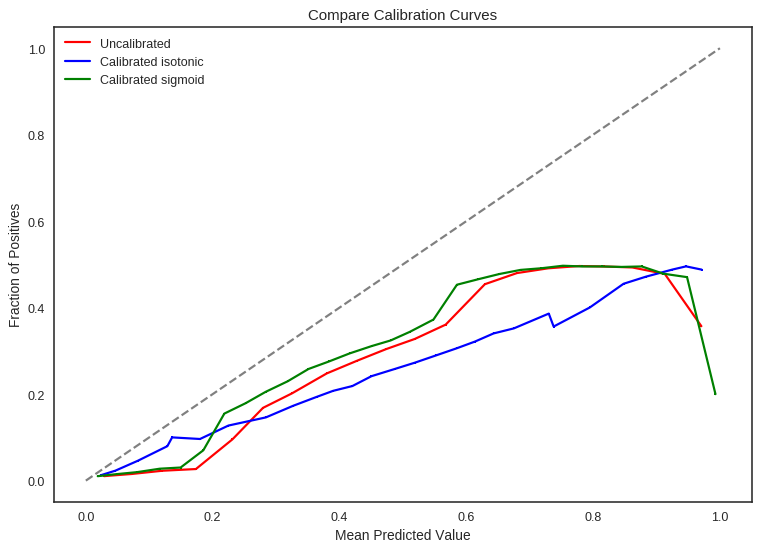

In [387]:
# use CalibratedClassifierCV with sigmoid and isotonic parameters

plt.figure(figsize=(10,7), dpi=90)
plt.style.use('seaborn-white')

preds_xgblr = lr.predict_proba(leaves_encoded_test)
max_proba = np.max(preds_xgblr[:,1])
min_proba = np.min(preds_xgblr[:,1])
scaled_proba_lr_test = [(proba-min_proba)/(max_proba-min_proba) for proba in preds_xgblr[:,1]]

fraction_of_pos, mean_pred_val = calibration_curve(y_test, scaled_proba_lr_test, n_bins=20)
plt.plot(mean_pred_val, fraction_of_pos, 's-', markersize=2, color='red', label='Uncalibrated')
plt.plot([0,1],[0,1],'--',color='gray')

methodlst=['isotonic','sigmoid',]
clr=['blue','green']
i=0
for method in methodlst:
    clf_calib=CalibratedClassifierCV(lr, cv='prefit', method=method, xdtype=pd.core.frame.DataFrame)
  
    clf_calib.fit(leaves_encoded_train, y_train)
     
    y_tst_clf_calib_proba=clf_calib.predict_proba(leaves_encoded_test)
    max_proba = np.max(y_tst_clf_calib_proba[:,1])
    min_proba = np.min(y_tst_clf_calib_proba[:,1])
    scaled_proba_lr_test = [(proba-min_proba)/(max_proba-min_proba) for proba in y_tst_clf_calib_proba[:,1]]    

    fraction_of_pos, mean_pred_val = calibration_curve(y_test, scaled_proba_lr_test, n_bins=30)
    plt.plot(mean_pred_val, fraction_of_pos, 's-', markersize=2, color=clr[i], label='Calibrated %s' % method)
    i=i+1
    
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.legend(loc='best')
plt.title('Compare Calibration Curves')
plt.show()

In [409]:
del leaves_encoded_test, leaves_encoded_train

In [410]:
gc.collect()

5571

## Precision/Recall: Compare XGB with XGB+LR

In [351]:
## After LR

threshold=0.30
y_pred_lr = binarize(preds_xgblr[:,1].reshape(-1, 1), threshold=threshold).reshape(-1)
recall_ts, precision_ts, f1_ts =  get_metrics(y_pred_lr.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.77413   0.56342   0.65217    922443
           1    0.42722   0.66452   0.52008    452018

    accuracy                        0.59667   1374461
   macro avg    0.60067   0.61397   0.58613   1374461
weighted avg    0.66004   0.59667   0.60873   1374461

Hold Out: 
Precision: 0.42722, Recall: 0.66452, F_1: 0.52008


In [346]:
# XGB only

threshold=0.5
y_pred_xgb = binarize(preds_xgb[:,1].reshape(-1, 1), threshold=threshold).reshape(-1)
recall_ts, precision_ts, f1_ts =  get_metrics(y_pred_xgb.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.75427   0.72150   0.73752    922443
           1    0.47794   0.52032   0.49823    452018

    accuracy                        0.65533   1374461
   macro avg    0.61610   0.62091   0.61787   1374461
weighted avg    0.66339   0.65533   0.65882   1374461

Hold Out: 
Precision: 0.47794, Recall: 0.52032, F_1: 0.49823


## Compine XGB Proba with LR

In [394]:
#LR proba
preds_xgblr = lr.predict_proba(leaves_encoded_test)
max_proba = np.max(preds_xgblr[:,1])
min_proba = np.min(preds_xgblr[:,1])
scaled_proba_lr_test = np.array([(proba-min_proba)/(max_proba-min_proba) for proba in preds_xgblr[:,1]]).reshape(-1,1)

#XGB proba
preds_xgb = xgb.predict_proba(X_test.astype(dtype=np.float32))
max_proba = np.max(preds_xgb[:,1])
min_proba = np.min(preds_xgb[:,1])
scaled_proba_xgb_test = np.array([(proba-min_proba)/(max_proba-min_proba) for proba in preds_xgb[:,1]]).reshape(-1,1)


In [395]:
scaled_proba_lr_test.shape, scaled_proba_xgb_test.shape

((1374461, 1), (1374461, 1))

In [402]:
proba_mix = np.concatenate([scaled_proba_lr_test,scaled_proba_xgb_test], axis=1)
avg_proba_mix = proba_mix.mean(axis=1)
avg_proba_mix.shape

(1374461,)

In [406]:
# XGB+LR only

threshold=0.5
y_pred_xgblr = binarize(avg_proba_mix.reshape(-1, 1), threshold=threshold).reshape(-1)
recall_ts, precision_ts, f1_ts =  get_metrics(y_pred_xgblr.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.75742   0.69744   0.72619    922443
           1    0.46846   0.54417   0.50349    452018

    accuracy                        0.64703   1374461
   macro avg    0.61294   0.62081   0.61484   1374461
weighted avg    0.66239   0.64703   0.65295   1374461

Hold Out: 
Precision: 0.46846, Recall: 0.54417, F_1: 0.50349


In [427]:
#compare with tuned XGB
y_pred = xgb.predict(X_test.astype(dtype=np.float32))

recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.75427   0.72150   0.73752    922443
           1    0.47794   0.52032   0.49823    452018

    accuracy                        0.65533   1374461
   macro avg    0.61610   0.62091   0.61787   1374461
weighted avg    0.66339   0.65533   0.65882   1374461

Hold Out: 
Precision: 0.47794, Recall: 0.52032, F_1: 0.49823


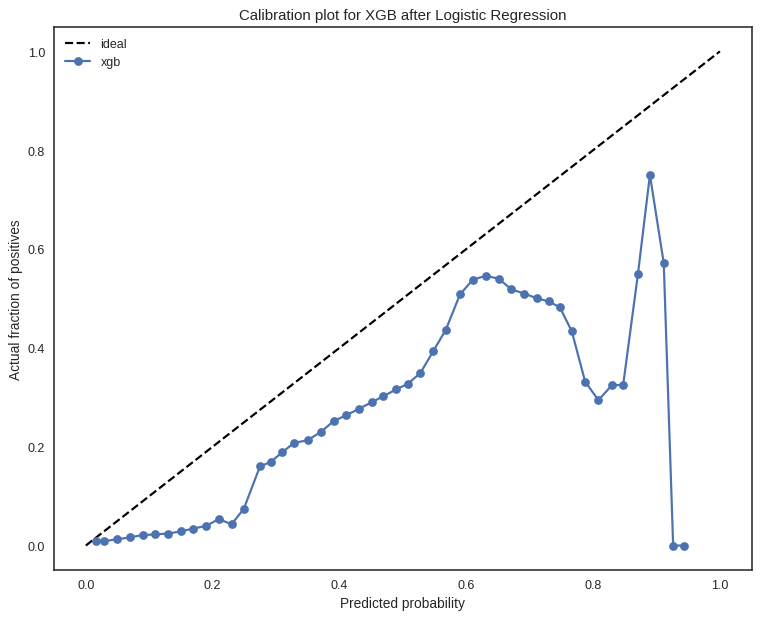

In [407]:
# creating a dataframe of target and probabilities
prob_df_xgblr = pd.DataFrame({'y':y_test, 'y_hat': avg_proba_mix}) #np.squeeze(preds_xgblr_scl)

# binning the dataframe, so we can see success rates for bins of probability
bins = np.arange(0.02, 1, 0.02)
prob_df_xgblr.loc[:,'prob_bin'] = np.digitize(prob_df_xgblr['y_hat'], bins)
prob_df_xgblr.loc[:,'prob_bin_val'] = prob_df_xgblr['prob_bin'].replace(dict(zip(range(len(bins)), bins)))

# opening figure
plt.figure(figsize=(10,8), dpi=90)
plt.style.use('seaborn-white')

# plotting ideal line
plt.plot([0,1],[0,1], 'k--', label='ideal')

# plotting calibration for xgb
calibration_y = prob_df_xgblr.groupby('prob_bin_val')['y'].mean()
calibration_x = prob_df_xgblr.groupby('prob_bin_val')['y_hat'].mean()
plt.plot(calibration_x, calibration_y, marker='o', label='xgb')

# legend and titles
plt.title('Calibration plot for XGB after Logistic Regression')
plt.xlabel('Predicted probability')
plt.ylabel('Actual fraction of positives')
plt.legend()
plt.show()